In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.rc('figure', figsize=(8,10))
plt.rc('font', size=14)
# plt.style.use('dark_background')
# plt.rc('figure',facecolor=(0,0,0,0)) # Set transparent background
%config InlineBackend.figure_format='retina'

In [2]:
import quflow as qf

# Generate random vorticity and plot it

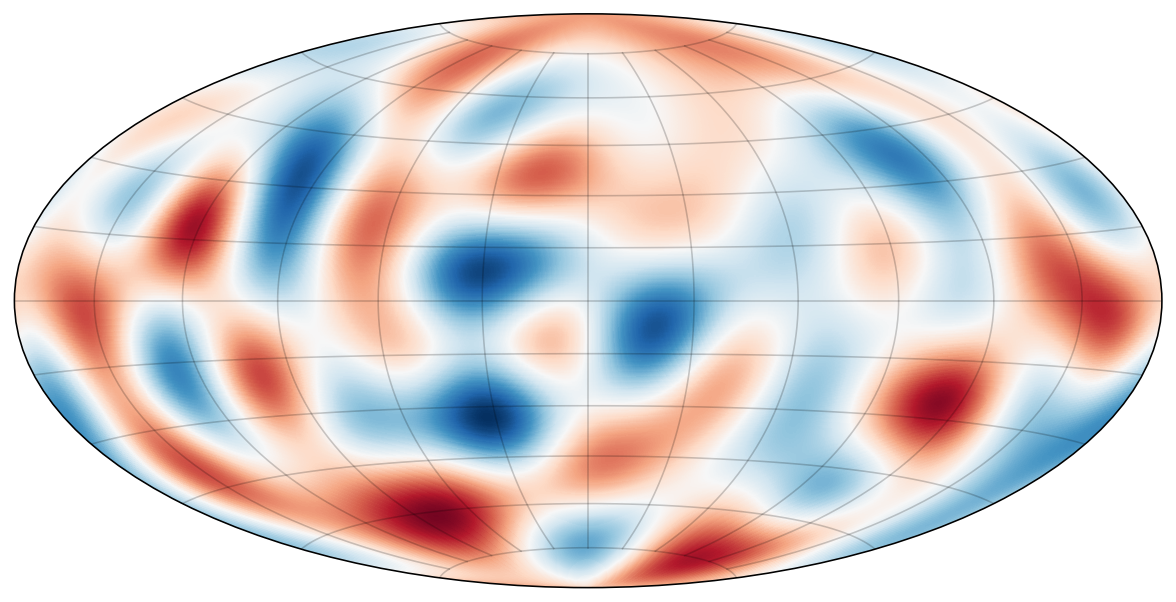

In [20]:
lmax = 10  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = np.random.randn(lmax**2)  # Array with SH coefficients
qf.plot2(omega0,projection='hammer', N=512)  # Plot command

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function
(related to $\omega$ via Poisson's equation).
The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix
$W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.

## Create initial conditions

In [10]:
N = 128  # Size of matrices
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix

## Run simulation

In [11]:
filename = "my_sim_N_{}.hdf5".format(str(N))
time = 5.0 # in second
inner_time = 0.2 # in seconds
qstepsize = 0.2 # in qtime

In [12]:
print("The physical stepsize is {:.3e} seconds.".format(qf.qtime2seconds(qstepsize, N)))

The physical stepsize is 3.462e-04 seconds.


In [13]:
# Callback data object
mysim = qf.QuData(filename)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Run simulation
qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim)

# Flush cache data
mysim.flush()

  0%|          | 0/14443 [00:00<?, ? steps/s]

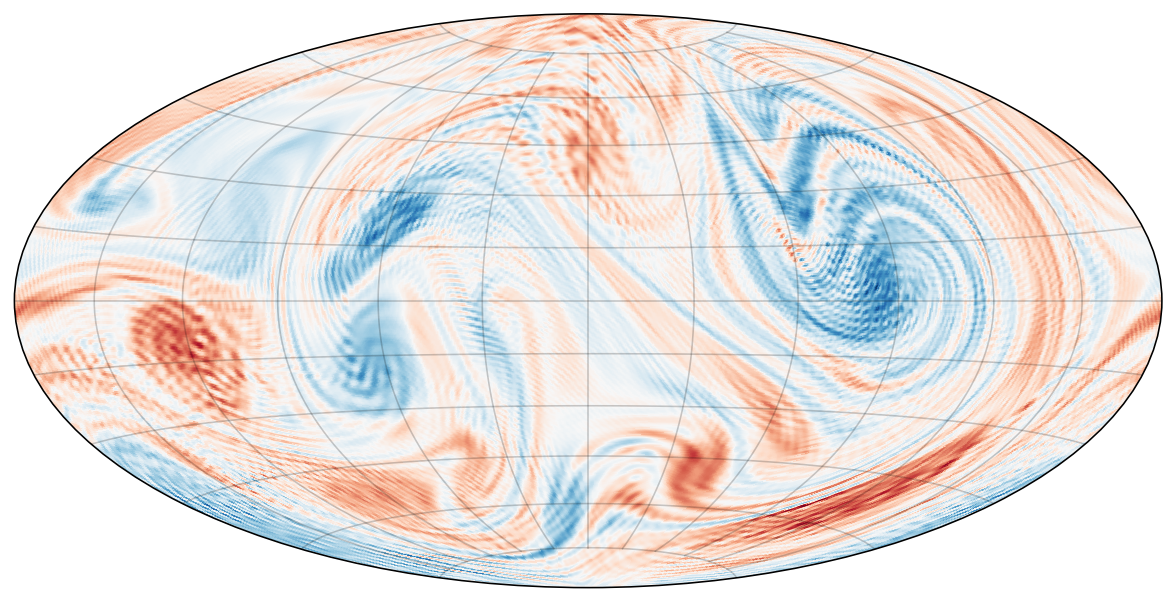

In [21]:
# Plot last state
omega = qf.load(filename)[-1]
qf.plot2(omega, projection='hammer', N=512)

## Animate the results

In [16]:
with h5py.File(filename, 'r') as data:
    anim = qf.create_animation2(filename.replace(".hdf5",".mp4"), data['state'], projection='hammer', N=256)
anim

  0%|          | 0/26 [00:00<?, ? frames/s]

## Compute canonical decomposition

In [17]:
[Ws,Wr]=qf.scale_decomposition(W)
P = qf.solve_poisson(W)

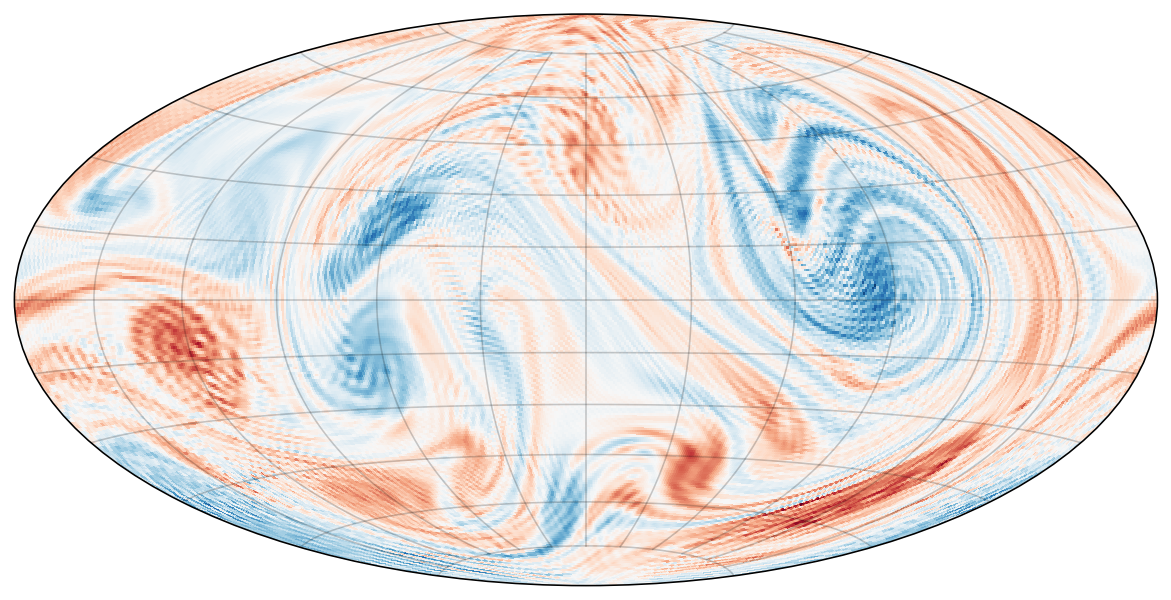

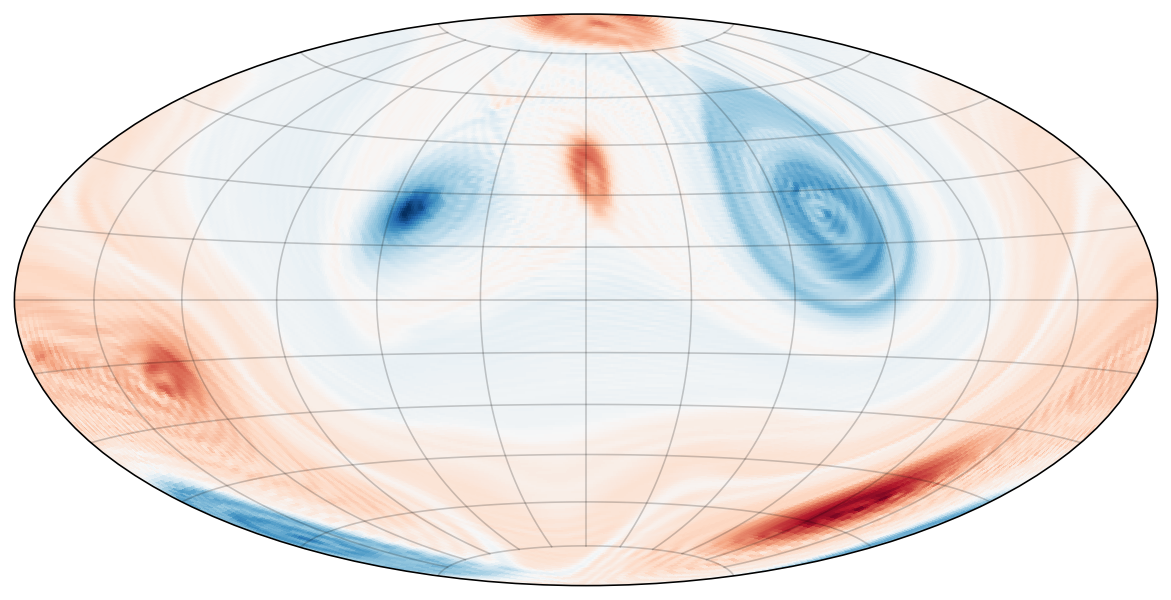

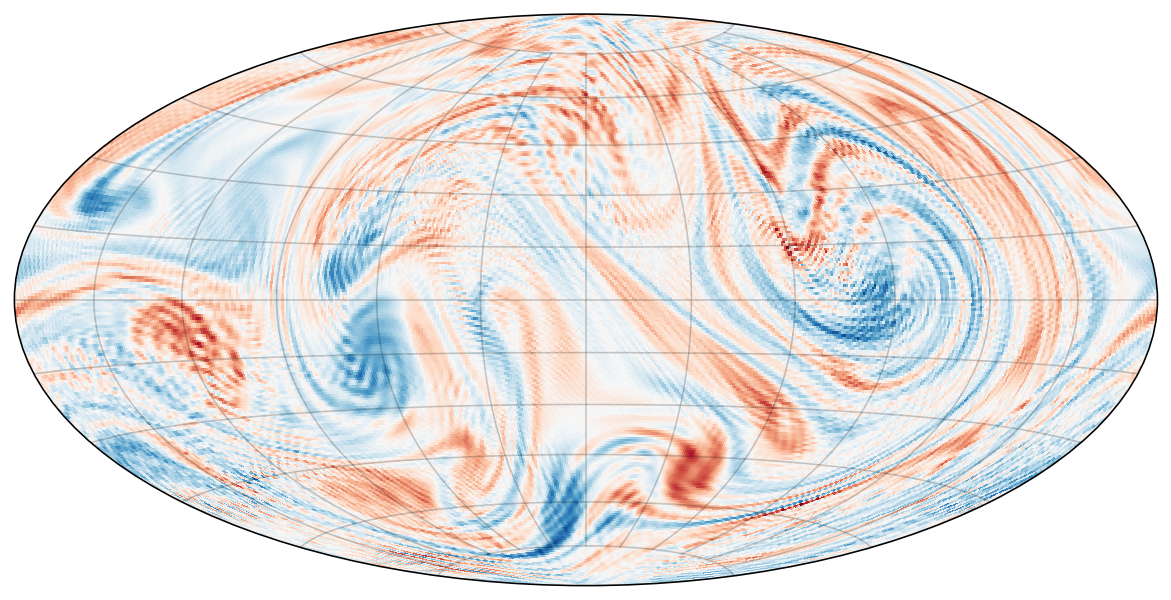

In [22]:
for Ww in [W, Ws, Wr]:
    qf.plot2(Ww, projection='hammer')